In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json
from os.path import expanduser
import glob
import os
import alphatims.bruker

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

minvi = 5000
FEATURES_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(minvi)))[-1]
FEATURES_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_DIR, experiment_name, run_name)

In [3]:
FEATURES_FILE

'/media/big-ssd/results-P3856-3did/minvi-5000-2021-09-09-16-40-10/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'

#### select a feature, or the stopping point

In [4]:
features_df = pd.read_feather(FEATURES_FILE)

In [5]:
len(features_df)

32333

In [6]:
# select a random feature of the most intense
features_df.sort_values(by=['feature_intensity'], ascending=False, inplace=True)
features_df.head(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
209,10518,72212
51,22651,81497
221,30897,67233


In [7]:
# select a random feature of the least intense
features_df.tail(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
31334,27144,1002
31033,43349,928
18157,13870,958


In [8]:
features_df[(features_df.voxel_id >= 960000000) & (features_df.voxel_id <= 960000050)]

,index,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
52,3,1052.994385,1053.061523,197.0,144.0,207.0,2192.924316,2189.750488,2196.100098,54708,...,"{""mz_lower"": 1052.546645, ""mz_upper"": 1056.55,...",960000012,"{""mz_lower"": 1053.5, ""mz_upper"": 1053.6, ""scan...","[{""scan"":138,""intensity"":4015,""filtered_intens...",0.999162,"[{""frame_id"":19622,""retention_time_secs"":2180....",0.999202,50642,0.999994,True
361,5,1057.020386,1057.087769,128.0,98.0,157.0,2177.047852,2174.403564,2179.694092,44316,...,"{""mz_lower"": 1056.5466450000001, ""mz_upper"": 1...",960000019,"{""mz_lower"": 1057.5, ""mz_upper"": 1057.60000000...","[{""scan"":88,""intensity"":284,""filtered_intensit...",0.998581,"[{""frame_id"":19482,""retention_time_secs"":2165....",0.995769,50644,0.979553,True
381,7,1058.410278,1058.477783,247.0,221.0,272.0,1819.817993,1817.172607,1822.994263,38826,...,"{""mz_lower"": 1057.946645, ""mz_upper"": 1061.95,...",960000031,"{""mz_lower"": 1058.9, ""mz_upper"": 1059.0, ""scan...","[{""scan"":208,""intensity"":259,""filtered_intensi...",0.985496,"[{""frame_id"":16077,""retention_time_secs"":1805....",0.994708,50646,0.977478,True
4087,2,1050.025024,1050.091919,165.0,155.0,175.0,2064.316162,2060.083984,2067.491455,47185,...,"{""mz_lower"": 1049.046645, ""mz_upper"": 1053.05,...",960000004,"{""mz_lower"": 1050.0, ""mz_upper"": 1050.1, ""scan...","[{""scan"":138,""intensity"":6733,""filtered_intens...",0.995873,"[{""frame_id"":18392,""retention_time_secs"":2050....",0.996460,50641,0.892453,True


In [9]:
selected_feature = features_df.loc[52].copy()

In [10]:
selected_feature

index                                                                                      3
mono_mz_lower                                                                    1052.994385
mono_mz_upper                                                                    1053.061523
scan_apex                                                                              197.0
scan_lower                                                                             144.0
scan_upper                                                                             207.0
rt_apex                                                                          2192.924316
rt_lower                                                                         2189.750488
rt_upper                                                                         2196.100098
intensity_without_saturation_correction                                                54708
intensity_with_saturation_correction                                  

In [11]:
# all features from the same voxel
features_df[(features_df.voxel_id == selected_feature.voxel_id)][['monoisotopic_mz','scan_apex','rt_apex','voxel_id','voxels_processed']]

,monoisotopic_mz,scan_apex,rt_apex,voxel_id,voxels_processed
52,1053.02832,197.0,2192.924316,960000012,"[960004098, 960000003, 960000005, 960000006, 9..."


In [12]:
# convert the metadata JSON to dicts
selected_feature.voxel_metadata_d = json.loads(selected_feature.voxel_metadata_d)
selected_feature.feature_region_3d_extent = json.loads(selected_feature.feature_region_3d_extent)

#### isotope extent in mobility

In [13]:
scan_df = pd.read_json(selected_feature.scan_df)

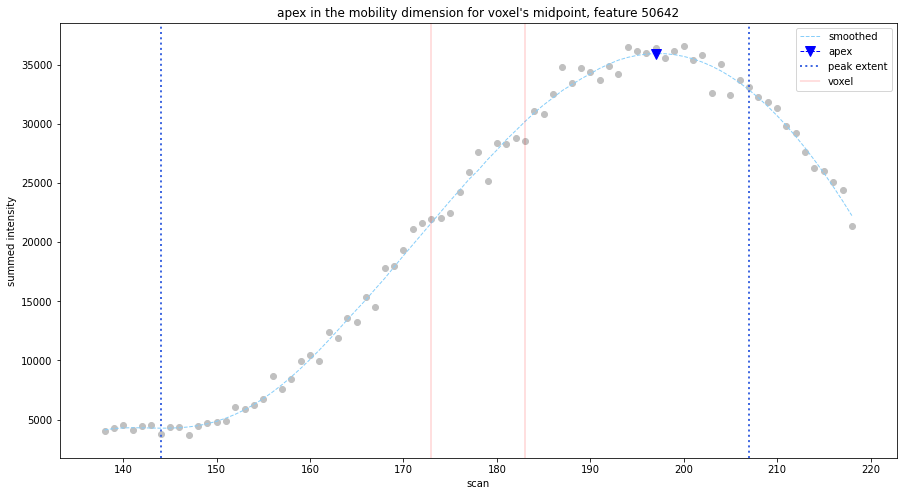

In [14]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.scan_apex, scan_df[scan_df.scan==selected_feature.scan_apex].iloc[0].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.axvline(x=selected_feature.voxel_metadata_d['scan_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['scan_upper'], linestyle='-', color='red', linewidth=0.25)

plt.title('apex in the mobility dimension for voxel\'s midpoint, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

In [15]:
print(selected_feature.scan_r_squared)

0.99916226


#### isotope extent in retention time

In [16]:
rt_df = pd.read_json(selected_feature.rt_df)

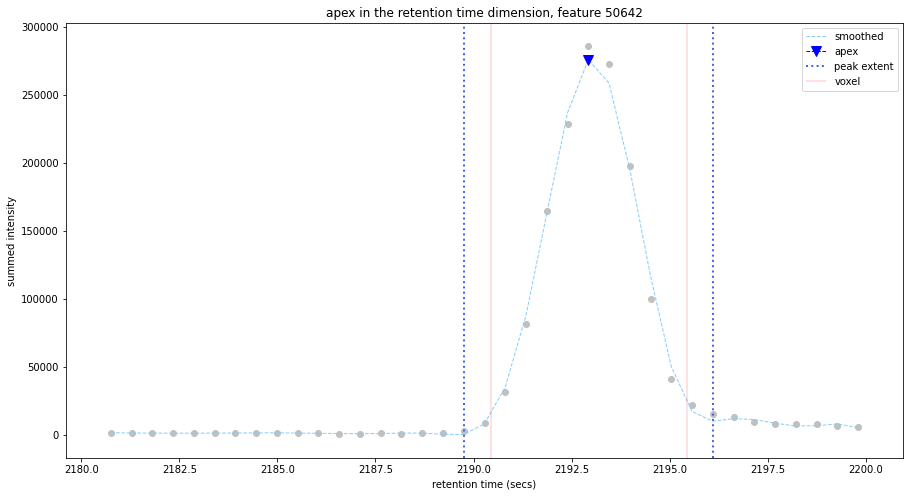

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.clipped_filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.rt_apex, rt_df[np.isclose(rt_df.retention_time_secs, selected_feature.rt_apex)].iloc[0].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.axvline(x=selected_feature.voxel_metadata_d['rt_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['rt_upper'], linestyle='-', color='red', linewidth=0.25)

plt.title('apex in the retention time dimension, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

In [18]:
print(selected_feature.rt_r_squared)

0.99920213


#### feature region in the voxel's most intense frame

In [19]:
rt_lower = selected_feature.rt_apex-20
rt_upper = selected_feature.rt_apex+20
scan_lower = int(min(selected_feature.scan_lower, selected_feature.voxel_metadata_d['scan_lower'], selected_feature.feature_region_3d_extent['scan_lower']))
scan_upper = int(max(selected_feature.scan_upper, selected_feature.voxel_metadata_d['scan_upper'], selected_feature.feature_region_3d_extent['scan_upper']))
mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
mz_upper = selected_feature.feature_region_3d_extent['mz_upper']

In [20]:
RAW_DATABASE_NAME = '/media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d'
RAW_HDF_PATH = RAW_DATABASE_NAME.replace('.d','.hdf')

In [21]:
# create the TimsTOF object
if not os.path.isfile(RAW_HDF_PATH):
    print('{} doesn\'t exist so loading the raw data from {}'.format(RAW_HDF_PATH, RAW_DATABASE_NAME))
    data = alphatims.bruker.TimsTOF(RAW_DATABASE_NAME)
    print('saving to {}'.format(RAW_HDF_PATH))
    _ = data.save_as_hdf(
        directory=os.path.split(RAW_HDF_PATH)[0],
        file_name=os.path.split(RAW_HDF_PATH)[1],
        overwrite=True
    )
else:
    print('loading raw data from {}'.format(RAW_HDF_PATH))
    data = alphatims.bruker.TimsTOF(RAW_HDF_PATH)

loading raw data from /media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.hdf


In [22]:
raw_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
raw_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
raw_df[int_columns] = raw_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
raw_df[float_columns] = raw_df[float_columns].apply(pd.to_numeric, downcast="float")

In [23]:
voxel_midpoint_rt_lower = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] - 0.5
voxel_midpoint_rt_upper = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] + 0.5
voxel_most_intense_frame_df = raw_df[(raw_df.retention_time_secs >= voxel_midpoint_rt_lower) & (raw_df.retention_time_secs <= voxel_midpoint_rt_upper)]

In [24]:
voxel_mz_lower = selected_feature.voxel_metadata_d['mz_lower']
voxel_mz_upper = selected_feature.voxel_metadata_d['mz_upper']
voxel_scan_lower = selected_feature.voxel_metadata_d['scan_lower']
voxel_scan_upper = selected_feature.voxel_metadata_d['scan_upper']

In [25]:
base_peak_mz_lower = selected_feature.voxel_metadata_d['iso_mz_lower']
base_peak_mz_upper = selected_feature.voxel_metadata_d['iso_mz_upper']
base_peak_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
base_peak_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']

In [26]:
feature_region_mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
feature_region_mz_upper = selected_feature.feature_region_3d_extent['mz_upper']
feature_region_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
feature_region_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']
feature_region_rt_lower = selected_feature.feature_region_3d_extent['rt_lower']
feature_region_rt_upper = selected_feature.feature_region_3d_extent['rt_upper']

In [27]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=raw_df.intensity.min(), vmax=raw_df.intensity.max(), clip=True)

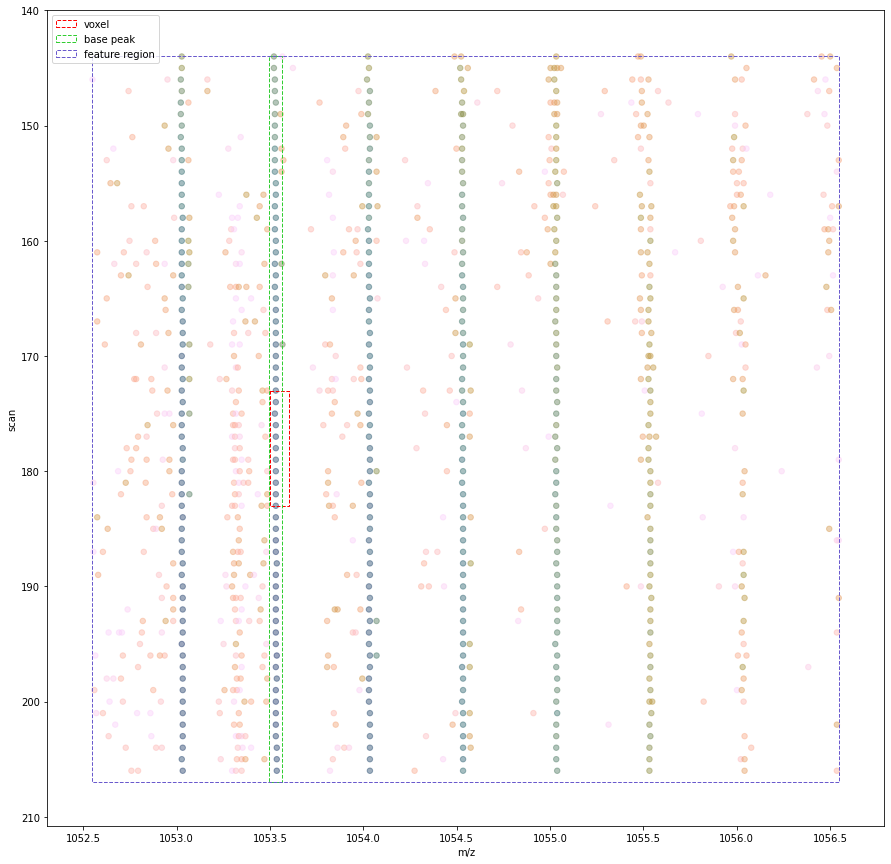

In [28]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(voxel_most_intense_frame_df.mz, voxel_most_intense_frame_df.scan, c=voxel_most_intense_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
# plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the voxel
top_left = (voxel_mz_lower,voxel_scan_lower)
width = voxel_mz_upper - voxel_mz_lower
height = voxel_scan_upper - voxel_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='red',facecolor='none',label='voxel')
ax1.add_patch(cuboid_rect)

# draw the base peak
top_left = (base_peak_mz_lower,base_peak_scan_lower)
width = base_peak_mz_upper - base_peak_mz_lower
height = base_peak_scan_upper - base_peak_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='limegreen',facecolor='none',label='base peak')
ax1.add_patch(cuboid_rect)

# draw the feature region for deconvolution
top_left = (feature_region_mz_lower,feature_region_scan_lower)
width = feature_region_mz_upper - feature_region_mz_lower
height = feature_region_scan_upper - feature_region_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(voxel_most_intense_frame_df.mz.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(voxel_most_intense_frame_df.scan.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

#### spectra deconvolution

In [29]:
feature_region_raw_df = raw_df[(raw_df.mz >= feature_region_mz_lower) & (raw_df.mz <= feature_region_mz_upper) & (raw_df.scan >= feature_region_scan_lower) & (raw_df.scan <= feature_region_scan_upper) & (raw_df.retention_time_secs >= feature_region_rt_lower) & (raw_df.retention_time_secs <= feature_region_rt_upper)].copy()
feature_region_raw_df['normalised_intensity'] = feature_region_raw_df.intensity / feature_region_raw_df.intensity.max()

In [30]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

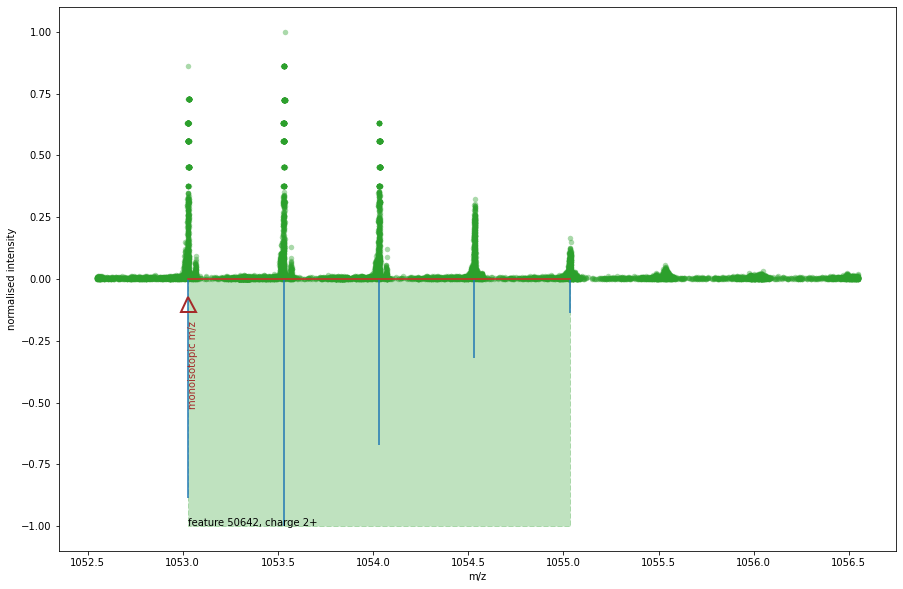

In [31]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(feature_region_raw_df.mz, feature_region_raw_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(selected_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(selected_feature.feature_id, selected_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(selected_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(selected_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(feature_region_raw_df.mz.min() / nearest) * nearest
range_u = round(feature_region_raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

In [32]:
selected_feature.charge

2